<a href="https://colab.research.google.com/github/mohamedsto7y/FASTai/blob/main/SyndromesClasification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

!pip install -Uqq fastbook
import fastbook
import os
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
key = os.environ.get('AZURE_SEARCH_KEY', '360f00a84c3d4c4a92b34e6dd52e1dc9')
search_images_bing


<function fastbook.search_images_bing>

In [4]:
syndrome_types = 'turner syndrome','klinefelter syndrome'
path = Path('syndrome')

In [11]:
if not path.exists():
    path.mkdir()
    for o in syndrome_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} real person')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)

In [13]:
failed = verify_images(fns)
failed.map(Path.unlink);


In [14]:
syndrome = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = syndrome.dataloaders(path)

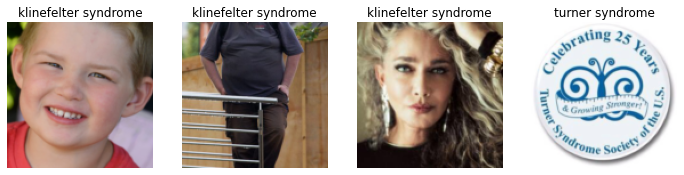

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

In [20]:
syndrome = syndrome.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
syndrome = syndrome.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = syndrome.dataloaders(path)


In [21]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.326247,0.738399,0.339623,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.875824,0.743015,0.358491,00:04
1,0.859147,0.718853,0.301887,00:04
2,0.792894,0.759229,0.320755,00:04
3,0.709870,0.925335,0.358491,00:04
4,0.654330,1.014693,0.358491,00:04
5,0.587424,0.973249,0.358491,00:04
6,0.542448,0.949947,0.358491,00:04
7,0.490600,0.921803,0.339623,00:04


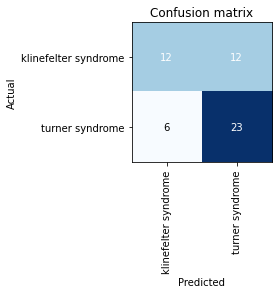

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

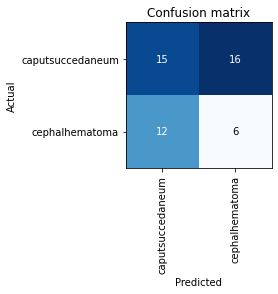

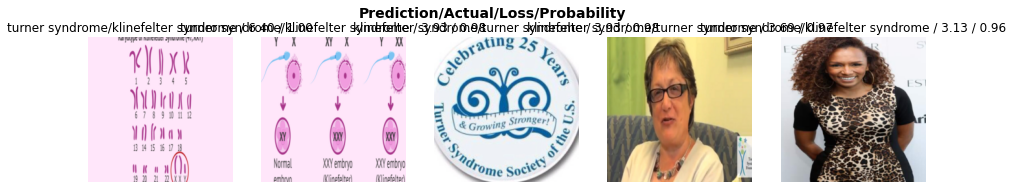

In [23]:
interp.plot_top_losses(5, nrows=1)

In [24]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [25]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()



Error: ignored

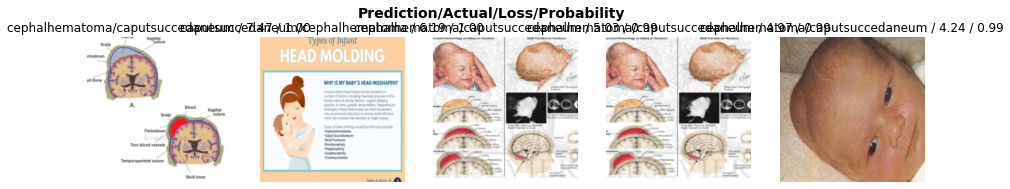

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [29]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')


In [30]:
learn_inf.dls.vocab

['klinefelter syndrome', 'turner syndrome']

In [32]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

In [33]:
img = PILImage.create(btn_upload.data[-1])


In [34]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [35]:
pred,pred_idx,probs = learn_inf.predict(img)

In [36]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: klinefelter syndrome; Probability: 0.6417')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [42]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [40]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [41]:
#hide_output
VBox([widgets.Label('Select the Syndrome!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()